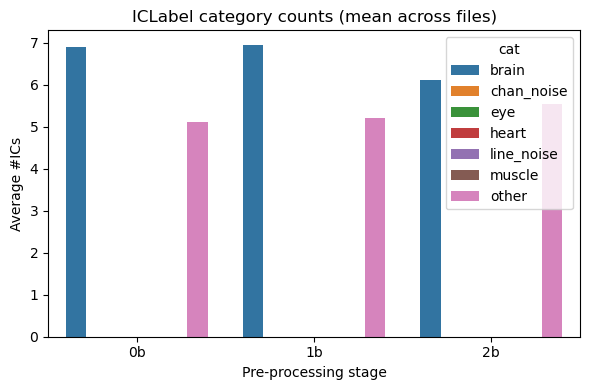

Reading D:\COGBCI\notebooks\..\data\preproc\sub-01_ses-S1_0b-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
201 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading D:\COGBCI\notebooks\..\data\preproc\sub-01_ses-S1_1b-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
196 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading D:\COGBCI\notebooks\..\data\preproc\sub-01_ses-S1_2b-epo.fif ...
    Read a total of 1 projection items:
        Average EEG

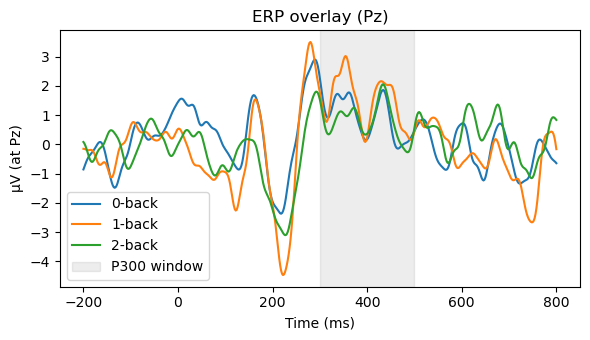

C:\Users\tp6mo\AppData\Local\Temp\ipykernel_14640\1957705838.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=theta_bar, x='load', y='theta', palette='Blues')


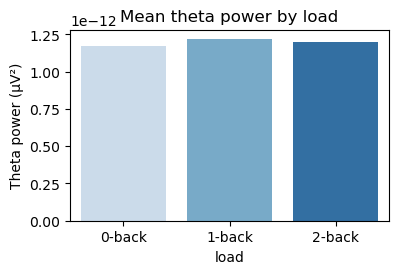

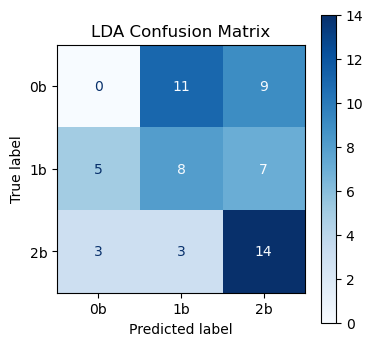

In [1]:
# 05_visualization_demo.ipynb
# ---------------------------
import pathlib, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import mne

ROOT     = pathlib.Path('..')            # notebooks/ 的上一層
FIG_DIR  = ROOT / 'figures'
FIG_DIR.mkdir(exist_ok=True)

# 1. ICLabel 三階段分類長條圖 --------------------------
df_ic = pd.read_csv(ROOT / 'results' / 'ICLabel_counts_all.csv')
# 加總三階段 brain / muscle / other …
df_bar = (df_ic
          .melt(id_vars=['sub','ses','cond'], var_name='cat', value_name='n')
          .groupby(['cond','cat'], as_index=False)['n'].mean())

plt.figure(figsize=(6,4))
sns.barplot(data=df_bar, x='cond', y='n', hue='cat')
plt.xlabel('Pre-processing stage')
plt.ylabel('Average #ICs')
plt.title('ICLabel category counts (mean across files)')
plt.tight_layout()
plt.savefig(FIG_DIR / 'iclabel_comparison.png', dpi=300)
plt.show()

# 2. ERP 疊圖 (0/1/2-back) --------------------------
# 以 sub-01_ses-S1 為示例
epo0 = mne.read_epochs(ROOT/'data/preproc/sub-01_ses-S1_0b-epo.fif', preload=False)
epo1 = mne.read_epochs(ROOT/'data/preproc/sub-01_ses-S1_1b-epo.fif', preload=False)
epo2 = mne.read_epochs(ROOT/'data/preproc/sub-01_ses-S1_2b-epo.fif', preload=False)

ev0, ev1, ev2 = epo0.average(), epo1.average(), epo2.average()
plt.figure(figsize=(6,3.5))
for ev, lab, col in zip([ev0, ev1, ev2], ['0-back','1-back','2-back'], ['C0','C1','C2']):
    plt.plot(ev.times*1e3, ev.data[ev.ch_names.index('Pz')]*1e6, label=lab, color=col)
plt.axvspan(300, 500, color='k', alpha=0.07, label='P300 window')
plt.xlabel('Time (ms)'); plt.ylabel('µV (at Pz)')
plt.title('ERP overlay (Pz)')
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / 'erp_overlay.png', dpi=300)
plt.show()

# 3. Theta power 長條圖 ----------------------------
df_feat = pd.read_csv(ROOT/'results/features_all.csv')
df_feat['load'] = df_feat['cond'].map({'0b':0,'1b':1,'2b':2})
theta_bar = (df_feat.groupby('load')['theta_mean']
             .mean().reset_index().rename(columns={'theta_mean':'theta'}))
plt.figure(figsize=(4,3))
sns.barplot(data=theta_bar, x='load', y='theta', palette='Blues')
plt.ylabel('Theta power (µV²)')
plt.xticks([0,1,2], ['0-back','1-back','2-back'])
plt.title('Mean theta power by load')
plt.tight_layout()
plt.savefig(FIG_DIR / 'theta_barplot.png', dpi=300)
plt.show()

# 4. 混淆矩陣 (先前分類腳本已存於 figures/?) -------
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np, joblib

# 假設已存 cross_val_predict 的 y_true, y_pred
y_true = np.load(ROOT/'results/y_true.npy')
y_pred = np.load(ROOT/'results/y_pred_lda.npy')
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=['0b','1b','2b'])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap='Blues')
ax.set_title('LDA Confusion Matrix')
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300)
plt.show()
